
## Customers Churning Prediction using Machine Learning

The objective of this project is to develop a Machine Learning Algorithm to predict which customers of a bank will leave their credit card services. We will use a dataset that has demographic information about the clients, records of the services they have hired with the bank and information about past transactions. The algorithm will take this data as input and predict if a client will churn or not. The data is publicly available on [Kaggle](https://www.kaggle.com/sakshigoyal7/credit-card-customers).

We will explore 3 different algorithms: Logistic Regression, Random Forest Classifiers and Neural Network Classifiers.

## Summary of Results

The dataset we used is unbalanced so we focused on the precision-recall trade-off more than in the overall precision.

The results for each model on the test set are:
- Logistic regression has a 90% accuracy (which is not high for an unbalanced dataset). It only had 57.5% precision for 80% recall, 52.9% recall for 80% precision, so we discarded it.
- Random Forest Classifier (RFC) has a 96.4% accuracy. It has 93.5% precision for 80% recall, and 92.6% for 80% precision.
- Neural Network Classifier (MLP) has a 95.3% accuracy. It has 90.2% precision for 80% recall, and 91.4% for 80% precision.
- The Ensembled model of Random Forest Classifier has a 96.7% accuracy. It has 94.8% precision for 80% recall, and 95.7% for 80% precision.

We found out that by combining the RFC and MLP the accuracy increased, and we reduced the trade-off between precision and recall.

# 1. Import Libraries

In [1]:
#Data Processing
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

#Fix Seaborn Kaggle Bug
#!pip install seaborn --upgrade

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

#Set visualization style
sns.set(style="whitegrid")
mpl.rcParams['figure.figsize'] = (6, 6)

# Ignore useless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Creates a count plot for 1 feature with percentages for each category

def plt_count(df, cat, title=None, ax=None):
    
    #Count values and percentages for each category in a categorical variable
    val_counts = df[cat].value_counts()
    per_counts = df[cat].value_counts(normalize=True)
    
    if ax==None:
        fig, ax = plt.subplots()
    
    val_counts.plot.bar(ax=ax)
    
    max_height = max([p.get_height() for p in ax.patches])
    min_height = min([p.get_height() for p in ax.patches])
    
    for i,p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{per_counts.iloc[i]:.1%}', (x + width/2, y+height+min_height*0.1), ha='center')
    
    ylim=max_height+max_height//2.5
    ax.set_ylim(0, ylim)
    
    if title==None:
        title=cat
    ax.set_title(title)
    plt.tight_layout()

# 2. Read in the Data

The data used in this project is publicly available on Kaggle and it's anonymized, so there are no privacy issues.

In [17]:
data = pd.read_csv('data.csv')

#The last 2 columns are predictions from previous models. We'll delete them, as they are irrelevant
data.drop(data.columns[-2:], axis=1, inplace=True) 

#Drop Client Id. It can create data leakage. A complex model may detect patterns in the customer id that will not be relevant in
#the future
data.drop(data.columns[0], axis=1, inplace=True) 

#Quick look at the Data
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

**Descriptions of the variables:**

**- Target Variable:**
- Attrition_Flag: 'Existing Customer' if the account is not closed, and 'Attrited Customer' if the account was closed.


**- Numeric Features:**

   - CLIENTNUM: Client number. Unique identifier for the customer holding the account.
   - Customer_Age: Demographic variable - Customer's Age in Years.
   - Customer_Age: Demographic variable - Number of dependents.
   - Marital_Status: Demographic variable - Married, Single, Divorced, Unknown.
   - Months_on_book: Period of relationship with bank.
   - Total_Relationship_Count: Total no. of products held by the customer.
   - Months_Inactive_12_mon: No. of months inactive in the last 12 months.
   - Contacts_Count_12_mon: No. of Contacts in the last 12 months.
   - Credit_Limit: Credit Limit on the Credit Card.
   - Total_Revolving_Bal: Total Revolving Balance on the Credit Card.
   - Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months).
   - Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1).
   - Total_Trans_Amt: Total Transaction Amount (Last 12 months).
   - Total_Trans_Ct: Total Transaction Count (Last 12 months).
   - Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1).
   - Avg_Utilization_Ratio: Average Card Utilization Ratio.
   
**- Categorical Features:**

   - Gender: Demographic variable - M=Male, F=Female.
   - Education_Level: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.).
   - Marital_Status: Demographic variable - Married, Single, Divorced, Unknown.
   - Income_Category: Demographic variable - Annual Income Category of the account holder.
   - Card_Category: Product Variable - Type of Card (Blue, Silver, Gold, Platinum).

Let's take a look at how many missing values there are in each column:

In [19]:
round((data=='Unknown').sum()/len(data)*100,1).astype(str)+'%'

Attrition_Flag               0.0%
Customer_Age                 0.0%
Gender                       0.0%
Dependent_count              0.0%
Education_Level             15.0%
Marital_Status               7.4%
Income_Category             11.0%
Card_Category                0.0%
Months_on_book               0.0%
Total_Relationship_Count     0.0%
Months_Inactive_12_mon       0.0%
Contacts_Count_12_mon        0.0%
Credit_Limit                 0.0%
Total_Revolving_Bal          0.0%
Avg_Open_To_Buy              0.0%
Total_Amt_Chng_Q4_Q1         0.0%
Total_Trans_Amt              0.0%
Total_Trans_Ct               0.0%
Total_Ct_Chng_Q4_Q1          0.0%
Avg_Utilization_Ratio        0.0%
dtype: object

We've got missing values in 3 columns, which are all categorical. We'll remove them when we pre-process the data.

Below is a plot of the target variable. This is a binary classification problem. We'll consider a customer churning as a positive result and not churning a negative result. We can see that there is an imbalance in the number of instances for each class. When we split the data into a train and a test sets we need to be careful about this imbalance.

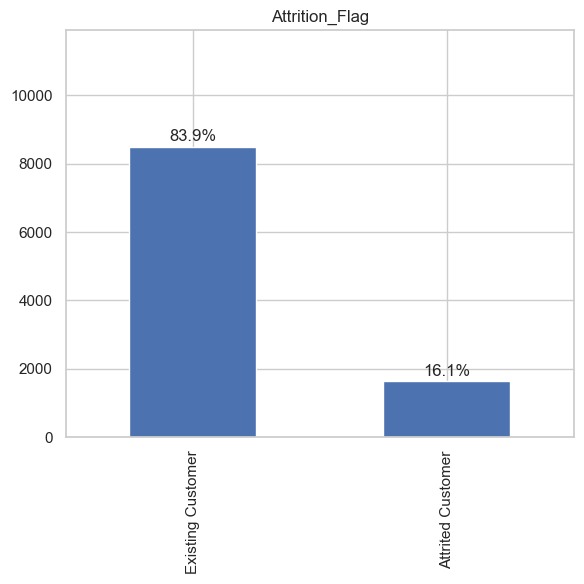

In [20]:
plt_count(data,'Attrition_Flag')

Now we need to create a test set and don't look at it. All the exploratory data analysis, experimenting with models and fine-tuning has to be done on the train set only. We should only use the test to get an estimate of the generalization error once we are ready to deploy a model, to prevent data snooping. We'll split the data so there's the same proportion of positives and negatives in the train set and the test sets.

In [21]:
#Use stratified sampling to split the dataset
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=10)
for train_index, test_index in split.split(data, data["Attrition_Flag"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

ModuleNotFoundError: No module named 'sklearn'

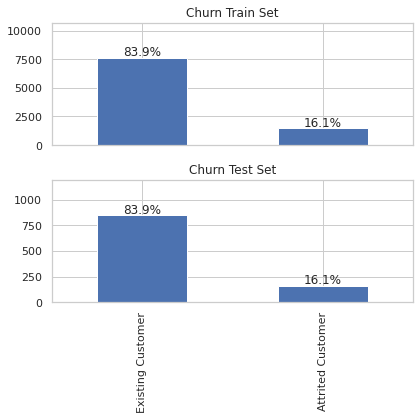

In [8]:
#Check the proportions are the same
fig, axes = plt.subplots(2,1,figsize=(6,6), sharex=True)
plt_count(df=train_set,cat='Attrition_Flag', title='Churn Train Set', ax=axes[0])
plt_count(df=test_set,cat='Attrition_Flag', title='Churn Test Set', ax=axes[1])

We'll make the target variable numerical:

In [9]:
target = 'Attrition_Flag'
train_set[target] = train_set[target].map({'Existing Customer':0, 'Attrited Customer':1})
test_set[target] = test_set[target].map({'Existing Customer':0, 'Attrited Customer':1})

# 3. Explore the Data

Before we start trying models on the data we need to explore the relationship between the target variable and the predictor features.

In [10]:
#Create a copy to avoid messing up the train dataset
churn = train_set.copy()

In [11]:
#Create separate lists of numeric and categorical features
num_vars = list(churn.select_dtypes(include=[np.number]).columns)
cat_vars = list(churn.select_dtypes(include=['object']).columns)
num_vars.remove('Attrition_Flag')

# 3.1 Categorical Features

Let's start with how the categorical variables are distributed:

In [12]:
#Plots the relationship between all the possible values in a categorical column and the target variable.
def plt_hue_cat(df, cat, target='Attrition_Flag', title=None, ax=None):
    #Create crosstab
    table = pd.crosstab(index=df[cat], columns=churn[target], normalize='index')
    
    if ax==None:
        fig, ax = plt.subplots()
    table.plot.bar(ax=ax)
    
    max_height = max([p.get_height() for p in ax.patches])
    min_height = min([p.get_height() for p in ax.patches])
    
    for i,p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{table.unstack().iloc[i]:.1%}', (x + width/2, y+height+min_height*0.1), ha='center')
    
    ylim=max_height+max_height
    ax.set_ylim(-.1, 1.1)
    y_vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

    if title==None:
        title=cat
        
    ax.set_title(title)
    ax.legend(loc=(1.1,0.5))
    plt.tight_layout()

Below we plot the number of instances and the percentage they represent of the total for each categorical feature:

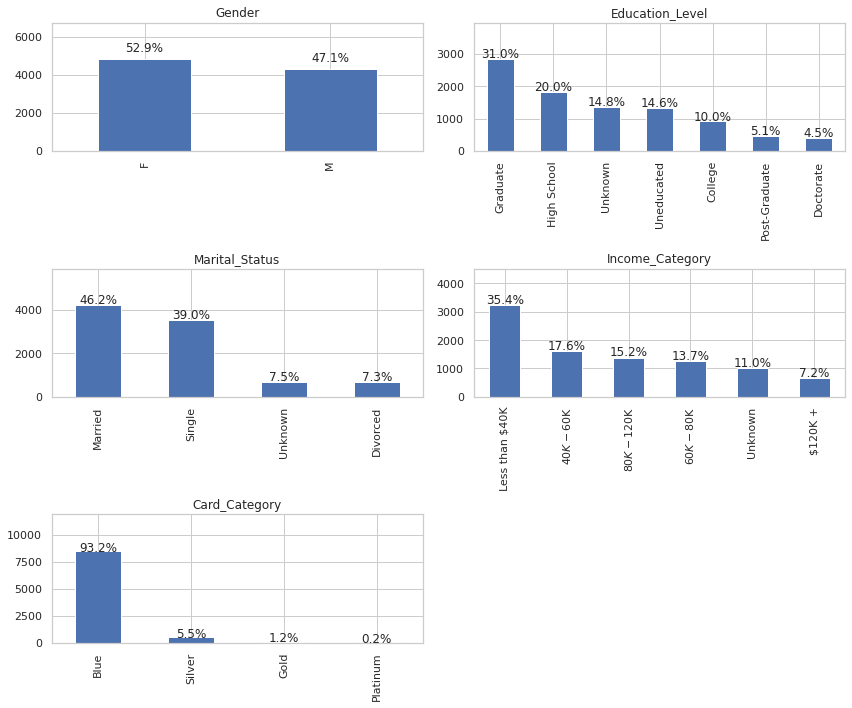

In [13]:
rows = len(cat_vars)//2+1
fig, axes = plt.subplots(rows, 2, figsize=(12,10))
axes = axes.ravel()
axes[-1].remove()

for i in range(len(cat_vars)):
    cat = cat_vars[i]
    plt_count(df=churn, cat=cat, ax=axes[i])

We don't know where this bank is located, so we can't find out if the demographic data is representative of the area it's located. The Gender variable seems balanced. The Card Category variable is likely to introduce noise in the model, due to the low number of observations for 3 out of 4 possible categories.

Let's plot the churn rate for each possible value of each category:

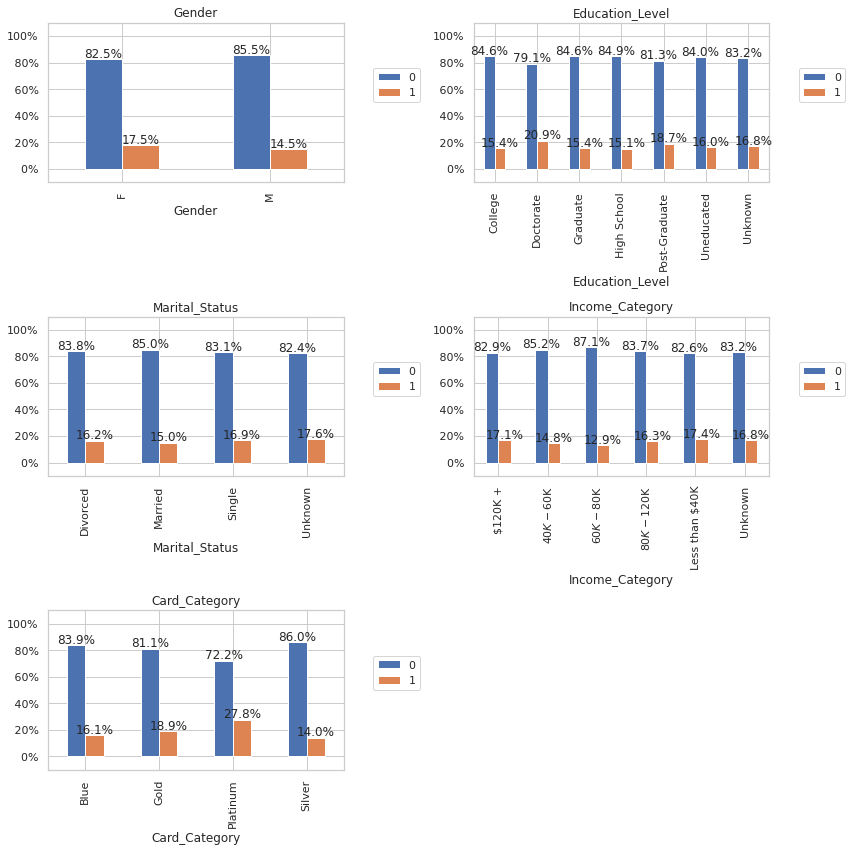

In [14]:
rows = len(cat_vars)//2+1
fig, axes = plt.subplots(rows, 2, figsize=(12,12))
axes = axes.ravel()
axes[-1].remove()

for i in range(len(cat_vars)):
    cat = cat_vars[i]
    plt_hue_cat(df=churn, cat=cat, ax=axes[i])
    
plt.show()

We can see that the churn rate differs across different demographics but not greatly. For instance, women are more likely to churn than men. Platinum customers are twice as likely than Silver customers. However, due to the low number of instances for these values, they are likely not to be significant and instead introduce noise on the model. In the rest of variables, the difference in churn rate is just a few percentage points.

Below we can see the churn rate for each combination of Education Level to Income:

In [15]:
churn.pivot_table(index='Income_Category', columns='Education_Level', 
                  values=target, aggfunc=lambda x: round(sum(x)/len(x),2)).iloc[[4,1,2,3,0]]

Education_Level,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Unknown
Income_Category,,,,,,,
Less than $40K,0.13,0.26,0.19,0.16,0.22,0.16,0.17
$40K - $60K,0.14,0.16,0.13,0.13,0.17,0.16,0.19
$60K - $80K,0.13,0.12,0.11,0.13,0.18,0.13,0.14
$80K - $120K,0.22,0.20,0.14,0.14,0.21,0.17,0.16
$120K +,0.17,0.24,0.16,0.18,0.13,0.19,0.16


We could create a more granular set of categories, but we've got a small dataset so we risk overfitting the data. The more complex algorithms we'll use will pick up on these patterns anyway.

Below we perform One-Hot-Encoding to plot the linear correlation between categorical and numeric features later:

In [16]:
def create_dummies(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df_mod = pd.concat([df, dummies], axis=1)
    df_mod = df_mod.drop([feature], axis=1)
    return(df_mod) 

for cat in cat_vars:
    churn = create_dummies(churn, cat)
    
churn

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
1619,0,53,3,36,4,2,4,11098.0,821,10277.0,0.896,2156,46,0.586,0.074,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
4028,0,38,5,25,4,3,0,5597.0,1118,4479.0,0.753,4599,89,0.648,0.200,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3297,0,65,1,36,3,2,3,4182.0,0,4182.0,0.691,4046,57,0.629,0.000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3087,0,65,1,36,5,1,2,5018.0,1131,3887.0,0.624,4028,81,0.800,0.225,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2830,0,46,4,35,5,2,3,2722.0,1473,1249.0,0.737,3129,69,0.683,0.541,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,1,59,2,36,3,3,3,1863.0,1853,10.0,0.829,2462,40,0.290,0.995,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
8109,1,41,2,33,1,3,3,1604.0,0,1604.0,0.644,2264,47,0.516,0.000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
7812,0,42,2,31,2,1,1,3659.0,0,3659.0,0.797,4068,61,0.694,0.000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
5151,0,52,3,36,4,2,3,2187.0,1094,1093.0,0.843,4222,61,0.649,0.500,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


# 3.2 Numerical Features

In [17]:
#Plot the distribution of a numeric variable with respect to the target variable
def plt_hue_num(df, num_var, target='Attrition_Flag', title=None, ax=None):
    
    if ax==None:
        fig, ax = plt.subplots()
    
    sns.histplot(df, x=num_var, hue=target, ax=ax)

    if title==None:
        title=num_var
        
    ax.set_title(title)
    plt.tight_layout()

Now we'll plot the distribution of the numeric features with respect to the target variable.

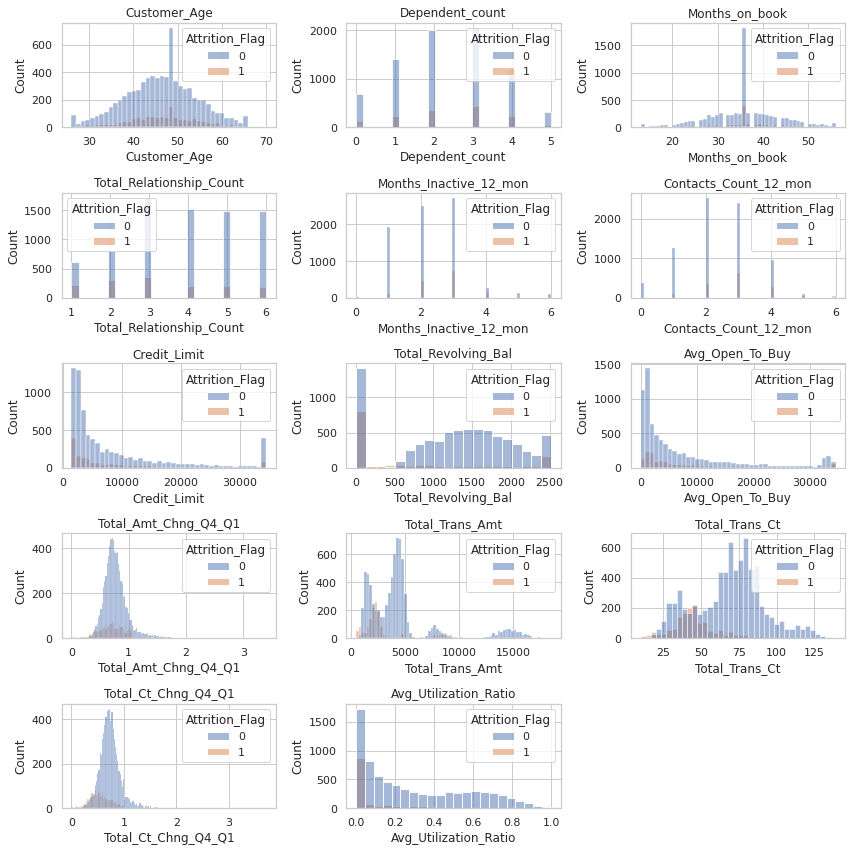

In [18]:
rows = len(num_vars)//3+1
fig, axes = plt.subplots(rows, 3, figsize=(12,12))
axes = axes.ravel()
axes[-1].remove()

for i in range(len(num_vars)):
    num_var = num_vars[i]
    plt_hue_num(churn, num_var, target='Attrition_Flag', ax=axes[i])    
    plt.tight_layout()
plt.show()

The variables that relate to the customers' transactions behaviour seem like way better predictors than the demographic features. The distribution for variables like the Average Utilization Rate and the Total Transaction amount are significantly skewed to the left for not churned customers than for not churned customers.

# 3.3 Correlation Matrix

Below we plot the correlation matrix for all variables:

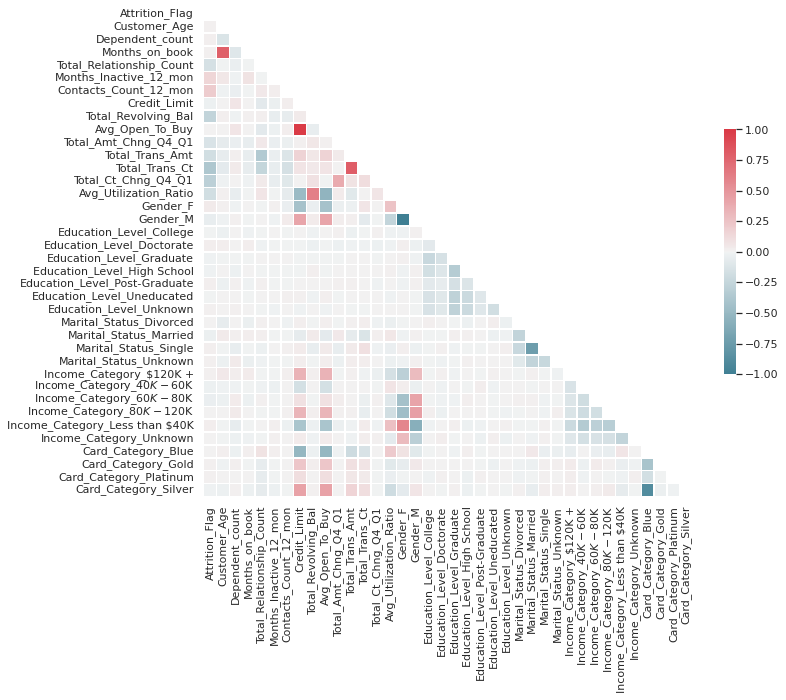

In [19]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(churn)

We can see that the target variable is linearly correlated only to the transaction information variables. There is some great collinearity between some of the features such as the Total Transaction Amount and the Average Transaction amount, which is logical. We need to be careful with it, as it could distort the model, especially simple linear models. More complex models like Decision Trees, which perform feature selection almost automatically, are way less affected. 

# 4. Prepare the Data for Machine Learning Algorithms

It's a good idea to write functions and pipelines for this purpose:
- It will automate the process if we get a new dataset. 
- It also allows us to build a library of functions that we can reuse in future projects.
- We can use this functions to transform the data on a live system.
- It makes it easier to try different transformations and see which combination yields the best results.

# 4.1 Categorical Features

In [20]:
#Revert to a clean dataset
y_train = train_set[target].copy()
X_train = train_set.drop(target, axis=1)

In [21]:
#Prepare Test Set for later
y_test = test_set[target].copy()
X_test = test_set.drop(target, axis=1)

In [22]:
#Import Scikit-Learn Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

We'll get rid of the missing values at the same time we perform OneHotEncoding. To avoid issues with collinearity, when we encode the categorical variables, we'll get rid of one of the possible values. We'll also get rid of the missing values by not including an Unknown category. 

In [23]:
#Get sets of categories for each categorical variable

categories = []

for cat in cat_vars:
    cat_add = train_set[cat].unique()
    cat_add = cat_add[cat_add!='Unknown']
    cat_add = cat_add[:-1]
    categories.append(cat_add)

In [24]:
#Create different pipelines for categorical and numeric features

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OneHotEncoder(categories=categories, handle_unknown='ignore')),
    ])

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [25]:
#Join the transformations for categorical and numeric features

prep_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_vars),
    ('num', num_pipeline, num_vars),
])

X_train_prep = prep_pipeline.fit_transform(X_train)

In [26]:
#Check that the transformed dataset shape is correct
X_train_prep.shape

(9114, 29)

# 5. Try different Models

In [27]:
#Import Scikit-Learn Libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [28]:
#Plots a confusion matrix for a binary classification problem
def plot_confusion_matrix(y_actual, y_pred, title=None):
    fig,ax = plt.subplots(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_actual,y_pred),
            annot=True, fmt='d',annot_kws={'size':16})
    ax.set_xticklabels(['Not Churn','Churn'],fontsize=14)
    ax.set_yticklabels(['Not Churn','Churn'],fontsize=14,rotation=0)
    ax.set_xlabel('Prediction',fontsize=16)
    ax.set_ylabel('Actual',fontsize=16)
    ax.set_title(title, fontsize=17, fontweight='bold')

# 5.1 Logistic Regression

Let's start with Logistic Regression, which is a simple linear model. 

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
#Train model on whole train set
lr = LogisticRegression()
lr.fit(X_train_prep, y_train)

LogisticRegression()

In [31]:
#Get accuracy on train set after training
y_pred = lr.predict(X_train_prep)
accuracy_score(y_pred, y_train)

0.9067368883037086

In [32]:
#Get cross-validated score on the train set
np.mean(cross_val_score(lr, X_train_prep, y_train, cv=10, scoring="accuracy"))

0.9047607699270129

The logistic regression model does not seem to be overfitting. 90% accuracy would be high if we had a balanced dataset. However, as 84% of the observations are negative, a classifier that only outputs negatives would have 84% accuracy, so this is not the best metric. Below we'll plot the confusion matrix and look at the precision and recall.

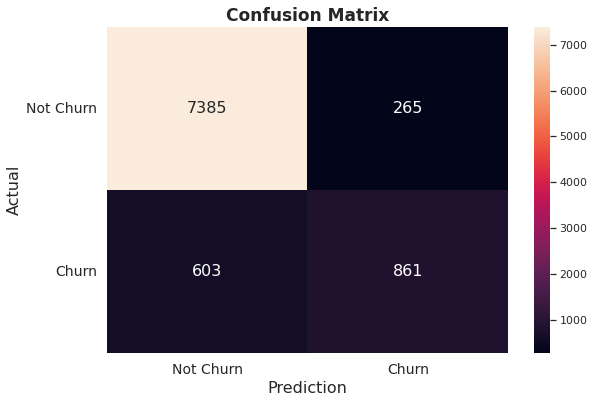

In [33]:
#Generate confusion matrix
y_pred = cross_val_predict(lr, X_train_prep, y_train, cv=10)
conf_matrix = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(y_train, y_pred, 'Confusion Matrix')

In [34]:
precision_score(y_train, y_pred)

0.7646536412078153

In [35]:
recall_score(y_train, y_pred)

0.5881147540983607

In [36]:
f1_score(y_train, y_pred)

0.664864864864865

Of all the instances labelled as positive, only 76% actually are, and it only identifies 59% of the customers who churn.

The Logistic Regression model outputs a probability for each instance that it belongs to a determined class. By default, if p>=0.5, the instance is labelled as positive, and if p<0.5, it's labelled as negative. We can tweak this threshold to increase recall at the expense of reducing precision and vice versa. Note that the overall accuracy might vary. 

Let's plot recall against precision to asses this trade-off: 

In [37]:
#Prepare data for plotting Precision-Recall Curve
y_scores = cross_val_predict(lr, X_train_prep, y_train, cv=10,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [38]:
def plot_precision_vs_recall(precisions, recalls, color='b', label=None, title=None, ax=None):
    if ax==None:
        fig, ax = plt.subplots(figsize=(8, 6))
    #Calculate points of 80% Recall and 80% Precision
    recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
    precision_80_recall = precisions[np.argmin(recalls >= 0.80)]
    
    ax.plot([recall_80_precision, recall_80_precision], [0., 0.8], "r:")
    ax.plot([0.0, recall_80_precision], [0.8, 0.8], "r:")
    ax.plot([recall_80_precision], [0.8], "ro")
    ax.plot([0., 0.8], [precision_80_recall, precision_80_recall], "g:")
    ax.plot([0.8, 0.8], [0.0, precision_80_recall], "g:")
    ax.plot([0.8],[precision_80_recall], "go")
    ax.plot(recalls, precisions, color, linewidth=1.5, label=label)
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_ylabel("Precision", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.axis([0, 1.05, 0, 1.05])
    plt.grid(True)

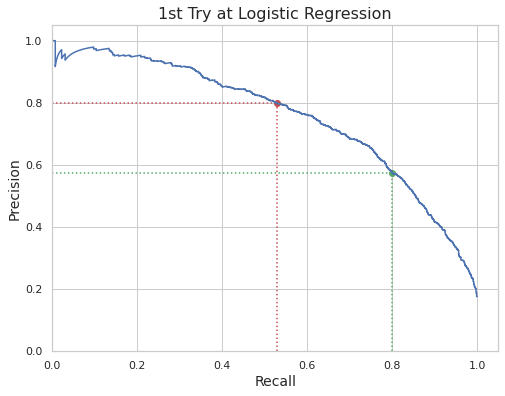

In [39]:
plot_precision_vs_recall(precisions, recalls, title='1st Try at Logistic Regression')
plt.show()

In [40]:
precision_80_recall = precisions[np.argmin(recalls >= 0.80)]
precision_80_recall

0.5754299754299754

In [41]:
recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
recall_80_precision

0.5293715846994536

If we want 80% recall we'll get 57.5% precision, and if we want 80% precision, we'll get 52.9% recall.

Let's look at the features importances:

In [42]:
#Look at feature importances
lr_coefs = lr.coef_[0]
feature_importances = abs(lr_coefs)
cat_encoder = prep_pipeline.named_transformers_["cat"]['encoder']
cat_one_hot_attribs = np.concatenate(cat_encoder.categories_).ravel().tolist()
attributes = cat_one_hot_attribs + num_vars #+ extra_attributes
sorted(zip(feature_importances, attributes), reverse=True)

[(2.738515745888756, 'Total_Trans_Ct'),
 (1.5886850647279704, 'Total_Trans_Amt'),
 (0.7431505304629931, 'Total_Revolving_Bal'),
 (0.6877269665312111, 'Blue'),
 (0.6801324992747517, 'Total_Ct_Chng_Q4_Q1'),
 (0.6780392890336829, 'Total_Relationship_Count'),
 (0.6210801929742532, 'F'),
 (0.5566761102434691, 'Contacts_Count_12_mon'),
 (0.5362230239022069, 'Months_Inactive_12_mon'),
 (0.5105337036026795, 'Married'),
 (0.3667309316802966, 'Gold'),
 (0.3652951193231604, '$40K - $60K'),
 (0.33679027279644214, 'Silver'),
 (0.3301349481441757, '$60K - $80K'),
 (0.2037233765560514, 'Graduate'),
 (0.17531023258628775, 'High School'),
 (0.17439320023907284, 'College'),
 (0.1670942780613567, 'Post-Graduate'),
 (0.1667267520292322, 'Dependent_count'),
 (0.12592603628079424, 'Uneducated'),
 (0.11326767258418047, 'Less than $40K'),
 (0.10114021762710981, 'Total_Amt_Chng_Q4_Q1'),
 (0.08743422770487685, 'Credit_Limit'),
 (0.0844116975502387, '$80K - $120K'),
 (0.0637141390882929, 'Single'),
 (0.060547488

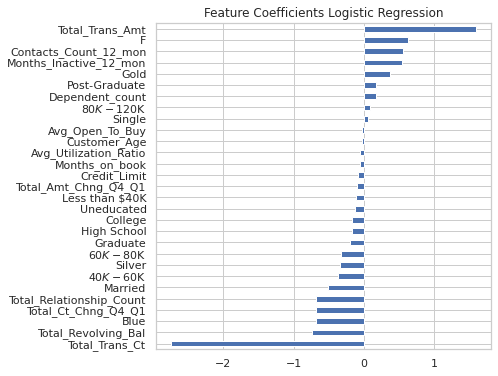

In [43]:
#Plot feature coefficients
ax = pd.Series(index=attributes, data=lr_coefs).sort_values().plot.barh()
ax.set_title('Feature Coefficients Logistic Regression')
plt.show()

We can see that the numeric features related to the transactions behaviour have the highest coefficients, as it was expected. We can also see the issues that multicollinearity causes. Both the Total Transaction Amount and the Count are negatively correlated to the target variable. However, the coefficient for Total Transaction Amount is positive. This happens as a result of the high linear correlation with the Total Transaction Count, which distorts the model fitting. 

To improve the performance of this model we could get rid of multicorrelated features, get rid of irrelevant features (the ones with the lowest absolute value for the logistic regression coefficients), and try both constraining and unconstraining the model. We could also break down some of the numeric features into categories, which would help capture the nonlinear relationships. However, there are more powerful models available that do this automatically, so let's explore them. 

# 5.2 Random Forest Classifier

We'll now try a more complex model: Random Forest Classifier. It is an ensemble of Decision Tree Classifiers, which don't assume that the data is linear, as opposed to Logistic Regression, but are prone to overfit. That is why we use an ensemble of them, to take advantage of how well they fit the training data, but reducing the overfitting to the noise.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = RandomForestClassifier(random_state=10)

In [46]:
#Train model on whole train set
rfc.fit(X_train_prep, y_train)

RandomForestClassifier(random_state=10)

In [47]:
#Get accuracy on train set after training
y_pred = rfc.predict(X_train_prep)
accuracy_score(y_train, y_pred)

1.0

We can see that the accuracy on the training data is 100%. The model is clearly overfitting. We will sort it by eliminating useless features and constraining the model.

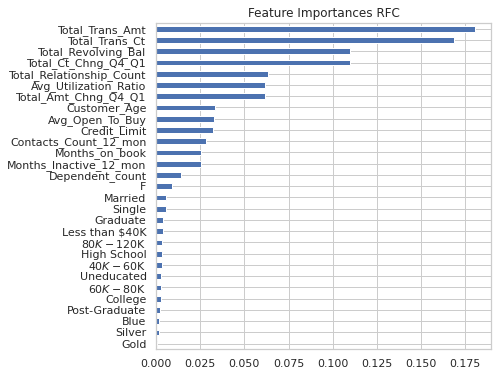

In [48]:
#Look at feature importances
feature_importances = rfc.feature_importances_
ax = pd.Series(index=attributes, data=feature_importances).sort_values().plot.barh()
ax.set_title('Feature Importances RFC')
plt.show()

We can see the RFC model identifies which features are the most important more accurately than Logistic Regression. All the top features are bank behaviour variables.

The cross-validated accuracy score is a lot higher than for Logistic Regression, as well as the recall and precision:

In [49]:
#Get cross-validated score on the train set
np.mean(cross_val_score(rfc, X_train_prep, y_train, cv=10, scoring="accuracy"))

0.9603912704373447

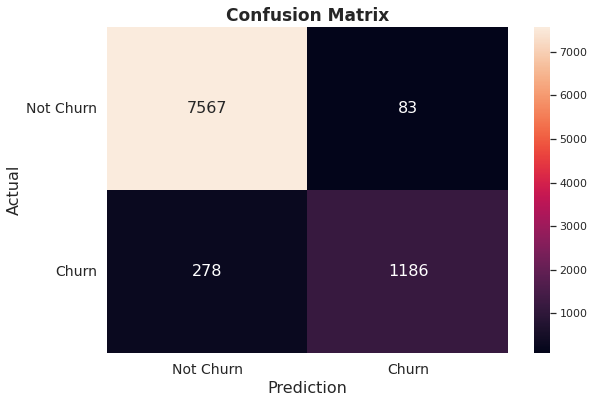

In [50]:
#Generate confusion matrix
y_pred = cross_val_predict(rfc, X_train_prep, y_train, cv=10)
conf_matrix = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(y_train, y_pred, 'Confusion Matrix')

We get a lot less false positives and false negatives.

In [51]:
accuracy_score(y_train, y_pred)

0.9603906078560457

In [52]:
precision_score(y_train, y_pred)

0.9345941686367218

In [53]:
recall_score(y_train, y_pred)

0.8101092896174863

In [54]:
f1_score(y_train, y_pred)

0.8679107208196121

In [55]:
#Prepare data for plotting Precision-Recall Curve
y_scores = cross_val_predict(rfc, X_train_prep, y_train, cv=10,
                             method="predict_proba")
y_scores = y_scores[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

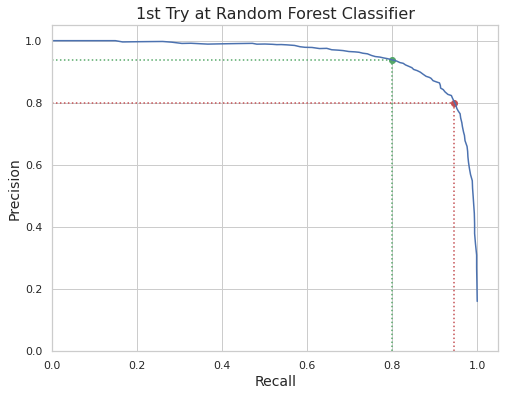

In [56]:
plot_precision_vs_recall(precisions, recalls, title='1st Try at Random Forest Classifier')
plt.show()

In [57]:
precision_80_recall = precisions[np.argmin(recalls >= 0.80)]
precision_80_recall

0.938301282051282

In [58]:
recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
recall_80_precision

0.9453551912568307

If we want 80% recall we'll get 93.8% precision, and if we want 80% precision we'll get 94.5% recall.

## Optimization

Now we will optimize the model, tuning the hyperparameters with GridSearch.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

#Get indexes of top features
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

#Select the best k-features
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]    

#Get pipeline with feature selection and model predictor
def get_fs_pred_pipeline(model):
    feature_select_and_predict_pipeline = Pipeline([
        ('feature_selection', TopFeatureSelector(feature_importances,k=1)),
        ('model', model)
    ])
    return feature_select_and_predict_pipeline

#Get pipeline with data preparation, feature selection and model predictor
def create_full_pipeline(model):
    pipeline = Pipeline([
        ('prep', prep_pipeline),
        ('fs_pred', model)
    ])
    return pipeline

In [60]:
#Get pipeline with feature selection and RFC predictor

fs_pred_rfc = get_fs_pred_pipeline(rfc)

Now we'll find the best combination of number of features, maximum depth of the classifier trees and maximum number of features used on each tree branch split using GridSearch:

In [61]:
param_grid = [{
   'feature_selection__k': list(range(7,len(feature_importances)-14)),
   'model__max_depth': list(range(2, 50)),
    'model__max_features': ['auto', 'none']
}]

grid_search = GridSearchCV(fs_pred_rfc, param_grid, cv=5,
                                scoring='accuracy', verbose=0)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        TopFeatureSelector(feature_importances=array([0.00886087, 0.00339211, 0.00252719, 0.00306271, 0.00408684,
       0.00207505, 0.00581266, 0.00536062, 0.00281065, 0.00407217,
       0.00317837, 0.00342469, 0.00183957, 0.00162018, 0.00075339,
       0.03330779, 0.01393609, 0.02559372, 0.06345637, 0.02559071,
       0.0281406 , 0.0319776....03258018, 0.06176758,
       0.18058731, 0.16859577, 0.10975001, 0.06179631]),
                                                           k=1)),
                                       ('model',
                                        RandomForestClassifier(random_state=10))]),
             param_grid=[{'feature_selection__k': [7, 8, 9, 10, 11, 12, 13, 14],
                          'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                        

In [62]:
grid_search.best_params_

{'feature_selection__k': 13,
 'model__max_depth': 17,
 'model__max_features': 'auto'}

We only need to use 13 features out of 29, and have a depth of 17 to get the best precision. Using a random subset of features on each branch split also reduces overfitting.

In [63]:
grid_search.best_score_

0.9640112647696556

We get a cross-validated calculated accuracy of 96.4%, which is higher than the first try, that had 96.0%. Because we have tried many different combinations of parameters on the same data, we risk having got a good result just by random chance, so we need to check the generalization error on the test set, which the algorithm has never seen:

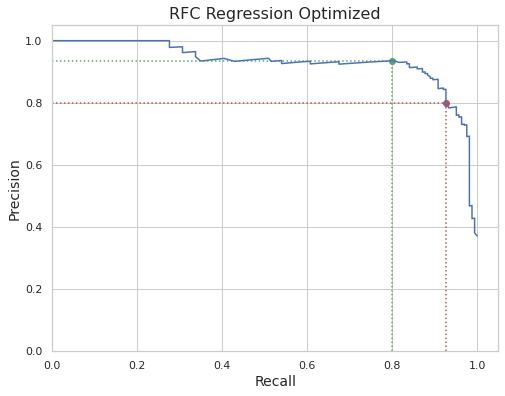

In [64]:
best_fs_rfc = grid_search.best_estimator_
best_rfc_full = create_full_pipeline(best_fs_rfc)

y_test_scores_rfc = best_rfc_full.predict_proba(X_test)[:,1]
precisions_rfc, recalls_rfc, thresholds_rfc = precision_recall_curve(y_test, y_test_scores_rfc)

plot_precision_vs_recall(precisions_rfc, recalls_rfc, title='RFC Regression Optimized')
plt.show()

In [65]:
precision_80_recall_rfc = precisions_rfc[np.argmin(recalls_rfc >= 0.80)]
precision_80_recall_rfc

0.935251798561151

In [66]:
recall_80_precision_rfc = recalls_rfc[np.argmax(precisions_rfc >= 0.80)]
recall_80_precision_rfc

0.9263803680981595

For the optimal hyperparametres, on the test set we get 93.5% precision for 80% recall, and 92.6% for 80% precision. These are the scores we present for our estimate accuracies of this model.

# 5.3 Neural Network Classifier

We'll try a Neural Network Classifier, which are great for capturing complex patterns on non-linear data.

In [67]:
from sklearn.neural_network import MLPClassifier

In [68]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', max_iter=1000)

The first try doesn't seem to overfit the model as much as the first RFC so it's a good start:

In [69]:
#Train model on whole train set
mlp.fit(X_train_prep, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)

In [70]:
#Get accuracy on the training set
y_pred = mlp.predict(X_train_prep)
accuracy_score(y_train, y_pred)

0.9728988369541365

In [71]:
#Get accuracy on train set after training
np.mean(cross_val_score(mlp, X_train_prep, y_train, cv=10, scoring="accuracy"))

0.9408603664760143

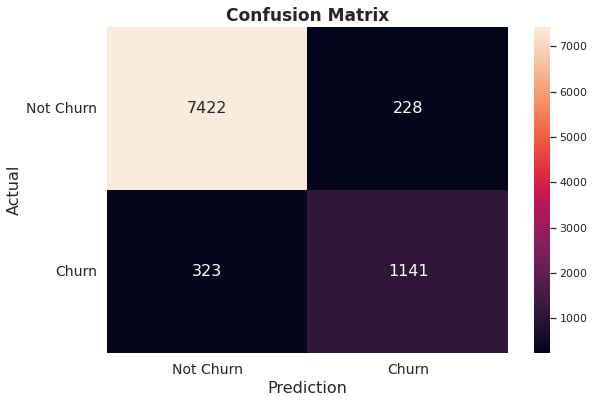

In [72]:
#Generate confusion matrix
y_pred = cross_val_predict(mlp, X_train_prep, y_train, cv=10)
conf_matrix = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(y_train, y_pred, 'Confusion Matrix')

In [73]:
accuracy_score(y_train, y_pred)

0.9395435593592275

In [74]:
precision_score(y_train, y_pred)

0.83345507669832

In [75]:
recall_score(y_train, y_pred)

0.7793715846994536

In [76]:
f1_score(y_train, y_pred)

0.8055065301800213

In [77]:
#Prepare data for plotting Precision-Recall Curve
y_scores = cross_val_predict(mlp, X_train_prep, y_train, cv=10,
                             method="predict_proba")
y_scores = y_scores[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

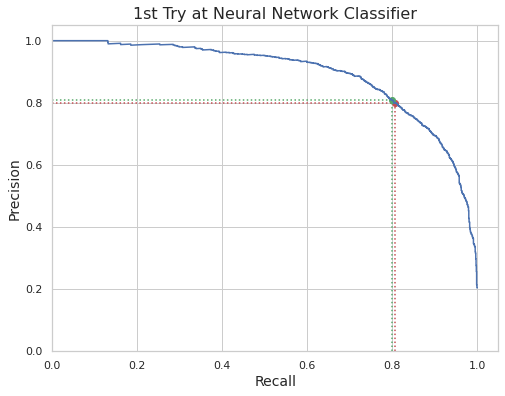

In [78]:
plot_precision_vs_recall(precisions, recalls, title='1st Try at Neural Network Classifier')
plt.show()

In [79]:
precision_80_recall = precisions[np.argmin(recalls >= 0.80)]
precision_80_recall

0.8087016574585635

In [80]:
recall_80_precision = recalls[np.argmax(precisions >= 0.80)]
recall_80_precision

0.8060109289617486

If we want 80% recall we'll get 94% precision, and if we want 80% precision we'll get 95% recall.

## Optimization

Now we will optimize the model, tuning the hyperparameters with GridSearch. Similar to what we did for Random Forest Classifiers. We'll find the best activation function and number of neurons in each layer. We won't perform feature selection for this algorithm, as it does it automatically.

In [81]:
param_grid = [{
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'hidden_layer_sizes':[(6,6),(8,8),(10,10)]
}]

In [82]:
grid_search = GridSearchCV(mlp, param_grid, cv=5,
                                scoring='accuracy', verbose=0)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=(10, 10),
                                     max_iter=1000),
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'hidden_layer_sizes': [(6, 6), (8, 8), (10, 10)]}],
             scoring='accuracy')

In [83]:
grid_search.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (8, 8)}

The parameters that produce the best cross-validated accuracy are:
- Using the hyperbolic tangent function as an activation function.
- 2 layers of 8 neurons each.

In [84]:
grid_search.best_score_

0.9538065564235018

We get a cross-validated calculated accuracy of 96.4%, which is higher than the first try, that had 96.0%. Because we have tried many different combinations of parameters on the same data, we risk having got a good result just by random chance, so we need to check the generalization error on the test set, which the algorithm has never seen:

In [85]:
best_mlp = grid_search.best_estimator_
best_mlp_full= create_full_pipeline(grid_search.best_estimator_)

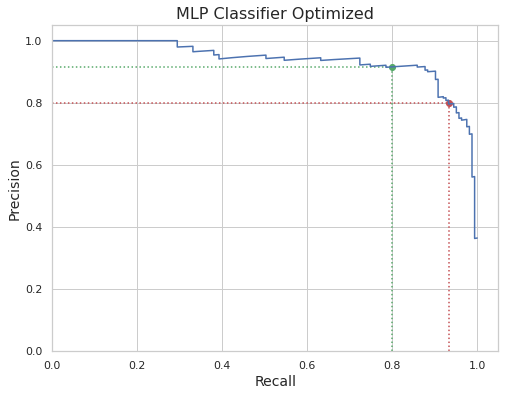

In [86]:
y_test_scores_mlp = best_mlp_full.predict_proba(X_test)[:,1]
precisions_mlp, recalls_mlp, thresholds_mlp = precision_recall_curve(y_test, y_test_scores_mlp)

plot_precision_vs_recall(precisions_mlp, recalls_mlp, title='MLP Classifier Optimized')
plt.show()

In [87]:
precision_80_recall_mlp = precisions_mlp[np.argmin(recalls_mlp >= 0.80)]
precision_80_recall_mlp

0.9154929577464789

In [88]:
recall_80_precision_mlp = recalls_mlp[np.argmax(precisions_mlp >= 0.80)]
recall_80_precision_mlp

0.9325153374233128

For the optimal hyperparametres, on the test set we get 90.2% precision for 80% recall, and 91.4% for 80% precision. These are the scores we present for our estimate accuracies of this model.

# 6. Create Ensembled Model

Now we'll create a model that combines the predictions of the RFC and the MLP classifiers. It will work by averaging the output probability of each model. Because they are different algorithms, we expect that the accuracy of the ensemble will be higher than of the individual predictors.

In [89]:
from sklearn.ensemble import VotingClassifier

In [90]:
#Combine the 2 predictors
voting_clf = VotingClassifier(
    estimators=[('rf', best_fs_rfc), ('mlp', best_mlp)],
    voting='soft')

#Create full pipeline for preparing data, feature selection and output prediction.
full_ensembled_clf = create_full_pipeline(voting_clf)
full_ensembled_clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[array(['F'], dtype=object),
                                                                                             array(['High School', 'College', 'Uneducated', 'Graduate',
       'Post-Graduate'], dtype=object),
                                                                                             array(['Married', 'Single'], dtype=object),
                                                                                             array(['$60K - $80K', 'Less than $4...
       0.00317837, 0.00342469, 0.00183957, 0.00162018, 0.00075339,
    

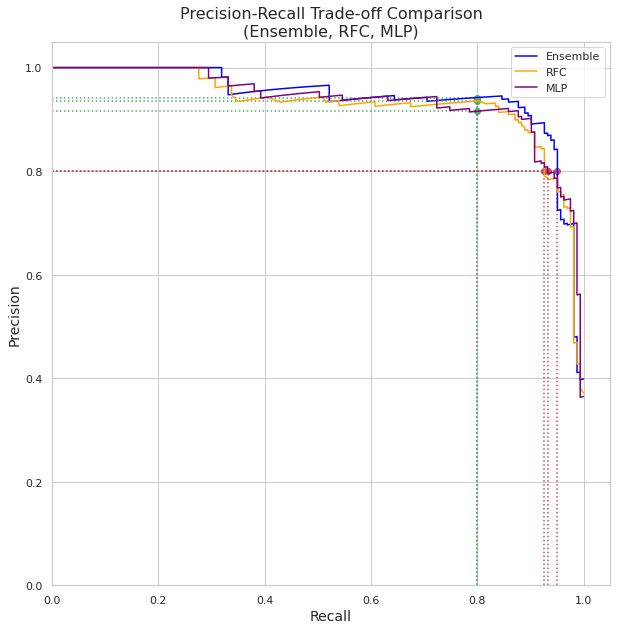

In [91]:
#Plot precision-recall curve for the individual algorithms and the ensemble.
y_test_scores_ens = full_ensembled_clf.predict_proba(X_test)[:,1]
precisions_ens, recalls_ens, thresholds_ens = precision_recall_curve(y_test, y_test_scores_ens)

fig, ax = plt.subplots(figsize=(10,10))

plot_precision_vs_recall(precisions_ens, recalls_ens, color='blue', label='Ensemble', ax=ax)
plot_precision_vs_recall(precisions_rfc, recalls_rfc, color='orange', label='RFC',ax=ax)
plot_precision_vs_recall(precisions_mlp, recalls_mlp, color='purple', label='MLP', 
                         title='Precision-Recall Trade-off Comparison\n(Ensemble, RFC, MLP)', ax=ax)
ax.legend()
plt.show()

In [92]:
y_pred_ens = full_ensembled_clf.predict(X_test)
accuracy_score(y_pred_ens, y_test)

0.9703849950641659

In [93]:
precision_80_recall_ens = precisions_ens[np.argmin(recalls_ens >= 0.80)]
precision_80_recall_ens

0.9420289855072463

In [94]:
recall_80_precision_ens = recalls_ens[np.argmax(precisions_ens >= 0.80)]
recall_80_precision_ens

0.950920245398773

For the ensemble model of RFC and MLP, on the test set we get 94.8% precision for 80% recall, and 95.7% for 80% precision. These are the scores we present for our estimate accuracies of this model. 

We successfully  created an ensemble that has higher accuracies than the individual models it's composed of. This is because both models make predictions differently, so the combination tends to be more accurate. It would be a good idea for expanding this project to add some new models to the ensemble such as Support Vector Machines and Gradient Boosting Classifiers. The more different these models are, the better the ensemble will be.